In [2]:
import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf

import wandb
wandb.login()
from wandb.keras import WandbCallback
wandb.init(project="AHW-CNN architecture")

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization

from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF, FactorAnalysis

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ahmedayman. Use `wandb login --relogin` to force relogin


In [48]:
# arabic_chars =list('ابتثجحخدذرزسشصضطظعغفقكلمنهوي')
# arabic_chars

In [9]:
x_train = pd.read_csv("./csvTrainImages 13440x1024.csv",header=None).to_numpy()
y_train = pd.read_csv("./csvTrainLabel 13440x1.csv",header=None).to_numpy()-1 

x_test = pd.read_csv("./csvTestImages 3360x1024.csv",header=None).to_numpy()
y_test = pd.read_csv("./csvTestLabel 3360x1.csv",header=None).to_numpy()-1

# print("x_train.shape =", x_train.shape)
# print("y_train.shape =", y_train.shape)
# print("x_test.shape =", x_test.shape)
# print("y_test.shape =", y_test.shape)

In [10]:
x_train = x_train.reshape(-1,32,32)
x_test = x_test.reshape(-1,32,32)
x_train = x_train/255
x_test = x_test/255

x_train = np.array([image.T for image in x_train])
x_test = np.array([image.T for image in x_test])

x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)


letter_data = np.concatenate((x_train, x_test))
letter_labels = np.concatenate((y_train, y_test))

print(letter_data.shape, letter_labels.shape)

letter_data = letter_data.reshape(-1,32,32, 1)
letter_labels = letter_labels.reshape(-1)

print(letter_data.shape, letter_labels.shape)

(16800, 32, 32) (16800, 1)
(16800, 32, 32, 1) (16800,)


In [51]:
# ra = np.random.randint(0, 13440, size=25)
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(x_train[ra[i]].reshape(32,32),"gray")
#     plt.title(arabic_chars[int(y_train[ra[i]][0])], fontsize = 20)
# plt.show()

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(letter_data, letter_labels, test_size=0.2)

In [53]:
# print(train_data.shape, train_labels.shape)
# print(test_data.shape, test_labels.shape)

In [12]:
train_data = train_data / 255.0
test_data = test_data / 255.0

train_labels = np_utils.to_categorical(train_labels)
test_labels = np_utils.to_categorical(test_labels)

In [55]:
# print(train_data.shape, test_data.shape)
# print(train_labels.shape, test_labels.shape)

In [13]:
train_label_counts = [0 for i in range(36)]
test_label_counts = [0 for i in range(36)]

for i in range(train_data.shape[0]):
  train_label_counts[np.argmax(train_labels[i])] += 1

for i in range(test_data.shape[0]):
  test_label_counts[np.argmax(test_labels[i])] += 1

In [57]:
# shuffled_data = shuffle(letter_data)
# rows, cols = 10, 10

# plt.figure(figsize=(20, 20))

# for i in range(rows * cols):
#   plt.subplot(cols, rows, i+1)
#   plt.imshow(shuffled_data[i].reshape(32, 32), interpolation="nearest", cmap="gray")

# plt.show()

In [58]:

# train_datagen=ImageDataGenerator(
#     #rescale=1/255, # Normalize the new images
#     zoom_range=0.2, #the amount of zooming u need
#     width_shift_range=0.10, # The percentage of Width shifitning
#     height_shift_range=0.10, # The percentage of height shifitning
#     shear_range=0.1, #Shear angle in counter-clockwise direction in degrees
#     fill_mode='nearest',
#     rotation_range=20, 
# )
# train_generator=train_datagen.flow(
#     x_train ,y_train ,batch_size=64
# )

# test_datagen=ImageDataGenerator()
# test_generator=test_datagen.flow(
#     x_test ,y_test ,batch_size=64
 
# )

In [59]:
earlystop = EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_accuracy',
    patience= 3,
    verbose=1,
)
callbacks = [earlystop, learning_rate_reduction]

In [6]:
model = Sequential()

model.add(Conv2D(80, (5, 5), input_shape=(32, 32, 1), activation="relu"))
model.add(BatchNormalization())

model.add(Conv2D(64, (5, 5), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(28, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()




# model=Sequential() 

# model.add(Conv2D(80,(5,5),activation='relu',input_shape=(32,32,1)))
# model.add(MaxPooling2D(2,2))
# model.add(Conv2D(64,(5,5),activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Flatten())
# model.add(Dense(1024,activation='relu', name='featurs'))
# #model.add(Dropout(0.5))
# model.add(Dense(28, kernel_regularizer=keras.regularizers.l2(0.01) ,activation='softmax'))
# model.compile(optimizer= 'adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 80)        2080      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 80)       320       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        128064    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                        

In [61]:
from keras.callbacks import ModelCheckpoint
best_loss_checkpoint = ModelCheckpoint(
    filepath="./models/best_loss_model.h5",
    monitor="loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

best_val_loss_checkpoint = ModelCheckpoint(
    filepath="./models/best_val_loss_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

In [62]:
# model.fit(
#     train_generator, 
#     epochs=1,
#     validation_data=test_generator,
#     callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
# )



history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels), 
    epochs=50, 
    batch_size=20, 
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint, WandbCallback()]
)

Epoch 1/50
672/672 [==============================] - ETA: 0s - loss: 1.4816 - accuracy: 0.5458

INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best)... Done. 0.2s


672/672 [==============================] - 61s 89ms/step - loss: 1.4816 - accuracy: 0.5458 - val_loss: 2.9890 - val_accuracy: 0.2807
Epoch 2/50
672/672 [==============================] - 61s 91ms/step - loss: 0.6303 - accuracy: 0.7868 - val_loss: 28.3260 - val_accuracy: 0.1923
Epoch 3/50
672/672 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.8656

INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best)... Done. 0.2s


672/672 [==============================] - 62s 92ms/step - loss: 0.3843 - accuracy: 0.8656 - val_loss: 2.0088 - val_accuracy: 0.5607
Epoch 4/50
672/672 [==============================] - 60s 90ms/step - loss: 0.3728 - accuracy: 0.8743 - val_loss: 5.4357 - val_accuracy: 0.2756
Epoch 5/50
672/672 [==============================] - 59s 88ms/step - loss: 0.2495 - accuracy: 0.9174 - val_loss: 7.4008 - val_accuracy: 0.3262
Epoch 6/50
672/672 [==============================] - 59s 88ms/step - loss: 0.2128 - accuracy: 0.9294 - val_loss: 2.1222 - val_accuracy: 0.6426
Epoch 7/50
672/672 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9413

INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best)... Done. 0.2s


672/672 [==============================] - 61s 91ms/step - loss: 0.1733 - accuracy: 0.9413 - val_loss: 1.3106 - val_accuracy: 0.7271
Epoch 8/50
672/672 [==============================] - 63s 94ms/step - loss: 0.1244 - accuracy: 0.9599 - val_loss: 2.1596 - val_accuracy: 0.6565
Epoch 9/50
672/672 [==============================] - 59s 88ms/step - loss: 0.1227 - accuracy: 0.9598 - val_loss: 1.4296 - val_accuracy: 0.7280
Epoch 10/50
672/672 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9545

INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best)... Done. 0.2s


672/672 [==============================] - 61s 91ms/step - loss: 0.1429 - accuracy: 0.9545 - val_loss: 1.2044 - val_accuracy: 0.7815
Epoch 11/50
672/672 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9637

INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best)... Done. 0.2s


672/672 [==============================] - 62s 92ms/step - loss: 0.1093 - accuracy: 0.9637 - val_loss: 1.0444 - val_accuracy: 0.8042
Epoch 12/50
672/672 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9690

INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best)... Done. 0.2s


672/672 [==============================] - 62s 92ms/step - loss: 0.0925 - accuracy: 0.9690 - val_loss: 0.9840 - val_accuracy: 0.8232
Epoch 13/50
672/672 [==============================] - 62s 92ms/step - loss: 0.1085 - accuracy: 0.9653 - val_loss: 9.4227 - val_accuracy: 0.3866
Epoch 14/50
672/672 [==============================] - 60s 90ms/step - loss: 0.0811 - accuracy: 0.9740 - val_loss: 3.6514 - val_accuracy: 0.5914
Epoch 15/50
672/672 [==============================] - 60s 90ms/step - loss: 0.0741 - accuracy: 0.9760 - val_loss: 1.1360 - val_accuracy: 0.8179
Epoch 16/50
672/672 [==============================] - 60s 89ms/step - loss: 0.0887 - accuracy: 0.9714 - val_loss: 11.9928 - val_accuracy: 0.4149
Epoch 17/50
672/672 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9771

INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best)... Done. 0.2s


672/672 [==============================] - 62s 92ms/step - loss: 0.0703 - accuracy: 0.9771 - val_loss: 0.9817 - val_accuracy: 0.8515
Epoch 18/50
672/672 [==============================] - 62s 92ms/step - loss: 0.0721 - accuracy: 0.9788 - val_loss: 1.2768 - val_accuracy: 0.8286
Epoch 19/50
672/672 [==============================] - 60s 89ms/step - loss: 0.0874 - accuracy: 0.9760 - val_loss: 1.0405 - val_accuracy: 0.8458
Epoch 20/50
672/672 [==============================] - 60s 89ms/step - loss: 0.0542 - accuracy: 0.9830 - val_loss: 2.0624 - val_accuracy: 0.7336
Epoch 21/50
672/672 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9829

INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Ahmed\Desktop\AHW\Final AHW ML Model\wandb\run-20221018_091156-zcrciv0a\files\model-best)... Done. 0.2s


672/672 [==============================] - 62s 92ms/step - loss: 0.0544 - accuracy: 0.9829 - val_loss: 0.9488 - val_accuracy: 0.8503
Epoch 22/50
672/672 [==============================] - 61s 91ms/step - loss: 0.0513 - accuracy: 0.9839 - val_loss: 10.7441 - val_accuracy: 0.4527
Epoch 23/50
672/672 [==============================] - 59s 88ms/step - loss: 0.0531 - accuracy: 0.9840 - val_loss: 131.9745 - val_accuracy: 0.0807
Epoch 24/50
672/672 [==============================] - 59s 88ms/step - loss: 0.0682 - accuracy: 0.9808 - val_loss: 1.5284 - val_accuracy: 0.8438
Epoch 25/50
672/672 [==============================] - 59s 88ms/step - loss: 0.0549 - accuracy: 0.9839 - val_loss: 3.5617 - val_accuracy: 0.5735
Epoch 26/50
672/672 [==============================] - 59s 88ms/step - loss: 0.0452 - accuracy: 0.9889 - val_loss: 20.3219 - val_accuracy: 0.1524
Epoch 27/50
672/672 [==============================] - 59s 87ms/step - loss: 0.0506 - accuracy: 0.9864 - val_loss: 26.8298 - val_accuracy:

In [63]:
model.load_weights("./models/best_val_loss_model.h5")

<AxesSubplot: >

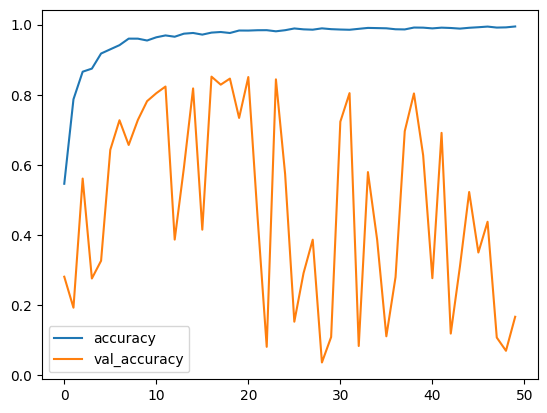

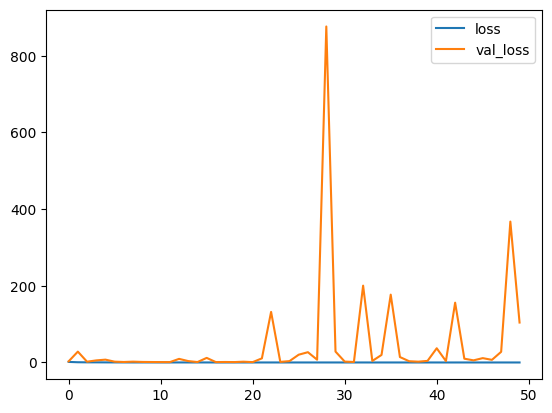

In [64]:
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [14]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_data)
confusion = confusion_matrix(
    np.argmax(test_labels, axis=1),
    np.argmax(predictions, axis=1)
)

labels = ['ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي']

df_cm = pd.DataFrame(confusion, columns=np.unique(labels), index = np.unique(labels))
df_cm.index.name = 'actual'
df_cm.columns.name = 'predicted'
plt.figure(figsize = (20,15))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 15}, fmt="d")

105/105 [==============================] - 3s 25ms/step


NameError: name 'sn' is not defined

<Figure size 2000x1500 with 0 Axes>

In [65]:
# model.evaluate(test_generator)

In [66]:
# pred = model.predict(x_test)
# print(pred.shape)
# pred = np.argmax(pred, axis=1)
# print(pred)

In [67]:
# print(classification_report(y_test, pred))

In [68]:
# from keras.models import Model

# layer_name = 'featurs'
# intermediate_layer_model = Model(inputs=model.input,
#                                  outputs=model.get_layer(layer_name).output)
# train_features = intermediate_layer_model.predict(x_train)

In [69]:
# not train_features.any()

In [70]:
# from sklearn.svm import SVC
# # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
# grid = {'C': [0.1, 1, 10, 100, 1000],
#         'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
#         'kernel': ['linear','rbf', 'poly', 'sigmoid']
#        }
# svm =SVC()
# svm_cv=HalvingGridSearchCV(svm,grid,cv=10)
# svm_cv.fit(train_features,y_train)

# print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
# print("accuracy :",svm_cv.best_score_)

In [71]:
# test_features = intermediate_layer_model.predict(x_test)

In [72]:
# svc =SVC(C = 10, gamma = 'scale', kernel = 'rbf')
# svc.fit(train_features,y_train)
# y_pred = svc.predict(test_features)

In [73]:
# print(classification_report(y_test, y_pred))

In [74]:
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.metrics import roc_auc_score

# # Learn to predict each class against the other
# classifier = OneVsRestClassifier(
#     SVC(C = 10, gamma = 'scale', kernel = 'rbf')
# )
# y_score = classifier.fit(train_features,y_train_h).decision_function(test_features)
# roc_auc_score(y_test_h, y_score)

In [75]:
# print(y_pred)

In [76]:
# i = 0 
# plt.figure(figsize = (20, 16))
# for j in range (len(y_test)):
#     if y_test[j] != y_pred[j]:
#         plt.subplot(6,8,i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.imshow(x_test[j].reshape(32,32),"gray")
#         plt.title('{} -> {}'.format(arabic_chars[int(y_test[j])], arabic_chars[int(y_pred[j])]), fontsize = 20)
#         #plt.xlabel(arabic_chars[int(y_test[j])], fontsize=20)
#         i+=1
#     if i >= 48:
#         break
# plt.show()
# plt.savefig('misclassified.png')